In [1]:
import os

import scgen
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import anndata
from tqdm.notebook import tqdm

from load_data import get_adata
from utils import remove_stimulated_for_celltype
from balance import balance_classes_up_inside_segments, balance_classes_down_inside_segments, balance_classes_inside_segments
from sc_condition_prediction import create_and_train_vae_model, evaluate_r2, evaluate_r2_custom, N_INPUT, N_LAYERS, N_HIDDEN, N_LATENT, BATCH_SIZE
from balance_experiments import train_valid_test_split, get_adatas_diversity_experiment


import warnings
warnings.filterwarnings('ignore')

# Initialize constants
load_dotenv()
CONDITION_KEY, CELL_TYPE_KEY = os.getenv('CONDITION_KEY'), os.getenv('CELL_TYPE_KEY')

# Load data
train_adata = get_adata()
train_new = remove_stimulated_for_celltype(train_adata, celltype="CD4T")


# parameters for our custom VAE model
model_params = dict(n_input=N_INPUT, 
                    n_layers=N_LAYERS, 
                    n_hidden=N_HIDDEN, 
                    n_latent=N_LATENT)

np.random.seed(43)

Global seed set to 0
c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\CSC2431 Artificial Intelligence in Medicine\Week 3\sc_env\lib\site-packages\pytorch_lightning\utilities\warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\CSC2431 Artificial Intelligence in Medicine\Week 3\sc_env\lib\site-packages\pytorch_lightning\utilities\warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` i

In [2]:
print(train_adata.obs.shape)
train_new.obs.groupby([CONDITION_KEY, CELL_TYPE_KEY]).size()

(16893, 5)


condition   cell_type  
control     CD4T           2437
            CD14+Mono      1946
            B               818
            CD8T            574
            NK              517
            FCGR3A+Mono    1100
            Dendritic       615
stimulated  CD4T              0
            CD14+Mono       615
            B               993
            CD8T            541
            NK              646
            FCGR3A+Mono    2501
            Dendritic       463
dtype: int64

## Class imbalance

This section include:
- Show cell type distribution on plot. We can see the imbalance on this plot as well.
- Perform artificial balancing using _resampling_ technique.

### Plot distribution by cell type

In [3]:
def plot_cell_type_distribution(adata):
    df_counts = (adata.obs
                 .groupby([CONDITION_KEY, CELL_TYPE_KEY])
                 .size()
                 .rename("count")
                 .to_frame()
                 .reset_index()
                )
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3), sharex=True, sharey=True)
    palette = ['grey', 'orange']
    conditions = df_counts[CONDITION_KEY].drop_duplicates().to_list()
    for i, condition in enumerate(conditions):
        df_counts[df_counts[CONDITION_KEY] == condition].plot(ax=axes[i], x=CELL_TYPE_KEY, y="count", kind="bar", color=palette[i], alpha=0.5)
        axes[i].set_title(condition)
        axes[i].get_legend().remove()

    plt.tight_layout(h_pad=10)
    fig.subplots_adjust(top=0.88)
    fig.suptitle("Distribution of cells", fontsize=14)
    return fig
    

## 1. Effect of upsampling on training


In [21]:
df_result = pd.read_csv(os.path.join('result',  "1 Effect of upsampling", "[cv 1].csv"), index_col=[0, 1])
set = 'validation'
df_result = df_result.loc[(slice(None), set), :].droplevel(1)
df_result['average'] = df_result.transpose().mean().values
df1 = df_result.reset_index()
df_result = df1[df1['index'] != 'balance upsampling'].append(df1[df1['index'] == 'balance upsampling'])
df_result = df_result.set_index('index')
df_result

,0,1,2,3,4,5,6,7,8,9,average
index,,,,,,,,,,,
original dataset,0.825046,0.817724,0.859664,0.863956,0.819205,0.840778,0.832479,0.841309,0.823389,0.818568,0.834212
balance downsampling,0.824402,0.836604,0.834934,0.822485,0.794956,0.821458,0.862055,0.804395,0.796922,0.808452,0.820666
balance to 600 instances,0.811445,0.806341,0.852307,0.846754,0.874886,0.874073,0.788641,0.824677,0.839568,0.818416,0.833711
balance to 800 instances,0.820158,0.870837,0.818655,0.817633,0.846160,0.819987,0.812826,0.832707,0.839389,0.841833,0.832018
balance to 1000 instances,0.860886,0.823254,0.826109,0.862914,0.801396,0.863738,0.844755,0.852985,0.842426,0.814369,0.839283
balance to 1200 instances,0.834430,0.831625,0.810120,0.833876,0.858428,0.832383,0.846413,0.855655,0.791188,0.833137,0.832726
balance to 1600 instances,0.808518,0.809611,0.846822,0.841697,0.834735,0.809930,0.846846,0.816938,0.805820,0.822004,0.824292
balance to 2000 instances,0.827011,0.788389,0.791262,0.792982,0.794892,0.793678,0.853491,0.803021,0.815906,0.822223,0.808285
balance upsampling,0.780582,0.774869,0.777822,0.842185,0.776056,0.837836,0.814979,0.834575,0.822508,0.820181,0.808159


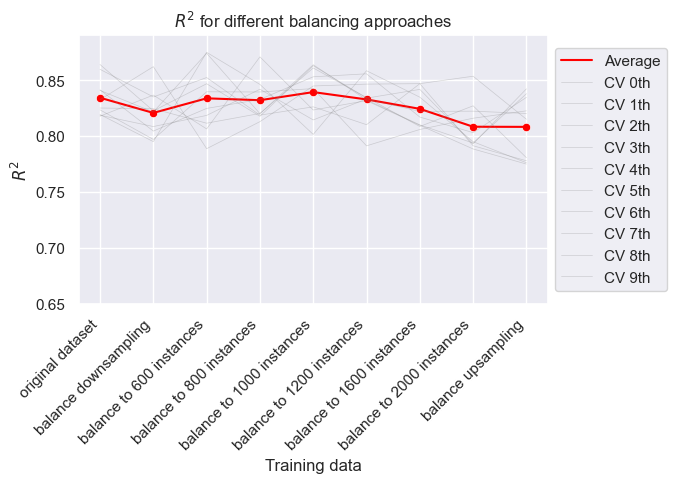

In [23]:
 
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("darkgrid")
plt.figure(figsize=(6, 5))
ax = plt.gca()
color = 'red' if set == 'validation' else 'blue'

df_result['average'].plot(rot=40, label='Average', color=color, ax=ax)
sns.scatterplot(df_result['average'], color=color)
cv_count = 10
for i in range(cv_count):
    df_result.iloc[:, i].plot(color='gray', alpha=0.3, lw=0.5,  label=f'CV {i}th', ax=ax)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('$R^2$ for different balancing approaches')
plt.ylabel('$R^2$')
plt.ylim([0.65, 0.89])
plt.xlabel('Training data')
plt.tight_layout()
plt.savefig(os.path.join('result', '1 Effect of upsampling', f'data-imbalance-method-effect-{set}.png'), dpi=300, bbox_inches='tight')

#### Plot Datasets

In [4]:
celltypes = train_new.obs[train_new.obs[CONDITION_KEY] == 'control'].groupby(CELL_TYPE_KEY).size().sort_values(ascending=False).index.to_list()
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854','#ffd92f', '#e5c494']
segment = 'control'

train_adata, adata_val, adata_test = train_valid_test_split(get_adata(dataset='kang', train=True))

original = train_adata
train_adata_balanced_up   = balance_classes_up_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False)
train_adata_balanced_down = balance_classes_down_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False)
train_adata_balanced_600  = balance_classes_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False, n=600)
train_adata_balanced_800  = balance_classes_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False, n=800)
train_adata_balanced_1000 = balance_classes_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False, n=1000)
train_adata_balanced_1200 = balance_classes_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False, n=1200)
train_adata_balanced_1400 = balance_classes_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False, n=1400)
train_adata_balanced_1600 = balance_classes_inside_segments(train_adata, class_key=CELL_TYPE_KEY, segment_key=CONDITION_KEY, verbose=False, n=1600)

datasets = {
              "original dataset": original, 
              "balance downsampling": train_adata_balanced_down,
              "balance to 600 instances": train_adata_balanced_600,
              "balance to 800 instances": train_adata_balanced_800,
              "balance to 1000 instances": train_adata_balanced_1000,
              "balance to 1200 instances": train_adata_balanced_1200,
              "balance to 1400 instances": train_adata_balanced_1400,
              "balance to 1600 instances" : train_adata_balanced_1600,
              "balance upsampling" : train_adata_balanced_up
             }

data = {
    "dataset_names": list(datasets.keys())
}

data.update({celltype: [] for celltype in celltypes})

for i, dataset in enumerate(datasets.values()):
    for celltype in celltypes:
        count = dataset[(dataset.obs[CELL_TYPE_KEY] == celltype) & (dataset.obs[CONDITION_KEY] == segment)].shape[0]
        data[celltype].append(count)

data
# -----------------------------------------------------
from bokeh.plotting import figure, output_notebook, show

output_notebook()

dataset_names = list(datasets.keys())
n_classes = len(celltypes)
p = figure(x_range=dataset_names, height=400, title=f"Datasets with different Balancing, {segment}",
           toolbar_location=None) #, tools="hover", tooltips="$nam @fruits: @$name")

p.vbar_stack(celltypes, x='dataset_names', width=0.8, source=data, color=palette[:n_classes], 
             legend_label=celltypes)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
# p.legend.location = "top_left"
# p.legend.orientation = "horizontal"
p.add_layout(p.legend[0], 'right')

p.xaxis.major_label_orientation = np.pi/4
p.right[0].items.reverse()
show(p)

Loading BokehJS ...

In [5]:
data

{'dataset_names': ['original dataset',
  'balance downsampling',
  'balance to 600 instances',
  'balance to 800 instances',
  'balance to 1000 instances',
  'balance to 1200 instances',
  'balance to 1400 instances',
  'balance to 1600 instances',
  'balance upsampling'],
 'CD4T': [2437, 517, 600, 800, 1000, 1200, 1400, 1600, 2437],
 'CD14+Mono': [1946, 517, 600, 800, 1000, 1200, 1400, 1600, 2437],
 'FCGR3A+Mono': [1100, 517, 600, 800, 1000, 1200, 1400, 1600, 2437],
 'B': [818, 517, 600, 800, 1000, 1200, 1400, 1600, 2437],
 'Dendritic': [615, 517, 600, 800, 1000, 1200, 1400, 1600, 2437],
 'CD8T': [574, 517, 600, 800, 1000, 1200, 1400, 1600, 2437],
 'NK': [517, 517, 600, 800, 1000, 1200, 1400, 1600, 2437]}

## 2.

- Cell types in order of number of cells (CD4T (2437), F-Mono (1100), B (818))
    
    800 cells in total for training 
    
    **question**: would the model learn better if only trained on 800 F-Mono (one cell type), or 800 B (one cell type), or 400 F-Mono_400 B (2 cell types)? 200 F-Mono + 600 B ? 600 F-Mono + 200 B (800 total training instances)
    
    Examine the effect of including more diverse sample during training (with same number of training samples) - **Pavlo**

<Figure size 640x480 with 0 Axes>

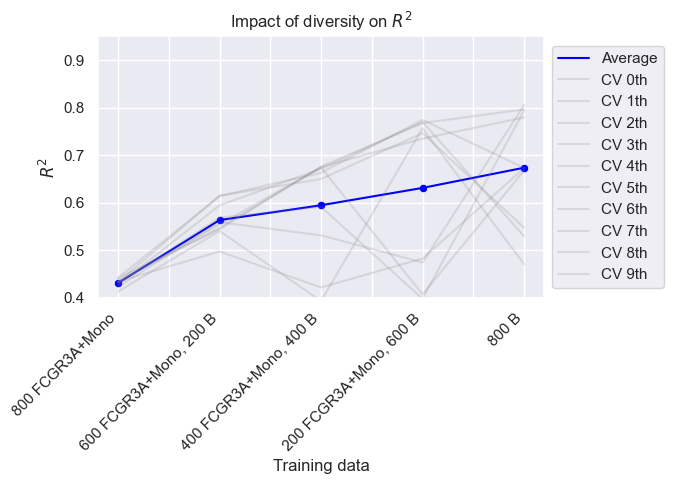

In [20]:

df_results = pd.read_csv(os.path.join('result', '2 Diversity', '[cv 1].csv'), index_col=[0, 1]).astype(float)
set = 'test'
df_results = df_results.loc[(slice(None), set), :].droplevel(1)

df_agg = df_results.transpose().mean()
# r2_scores, index = df_agg.

# 
import seaborn as sns
import matplotlib.pyplot as plt
plt.tight_layout(h_pad=5, w_pad=5)

sns.set_theme('notebook')
sns.set_style('darkgrid')

plt.figure(figsize=(6, 5))
ax = plt.gca()

color = 'red' if set == 'validation' else 'blue'
df_agg.plot(rot=40, label='Average', color=color, ax=ax)
sns.scatterplot(df_agg, color=color)

for i in range(df_results.shape[1]):
    df_results.iloc[:, i].plot(color='gray', alpha=0.2, label=f'CV {i}th', ax=ax)



ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Impact of diversity on $R^2$')
plt.ylabel('$R^2$')
plt.xlabel('Training data')
plt.ylim([0.4, 0.95])
plt.tight_layout()
plt.savefig(os.path.join('result', '2 Diversity', f'diversity-effect-{set}.png'), dpi=300, bbox_inches='tight');


#### Bokeh plot of data

In [ ]:
celltypes = train_new.obs[train_new.obs[CONDITION_KEY] == 'control'].groupby(CELL_TYPE_KEY).size().sort_values(ascending=False).index.to_list()
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854','#ffd92f', '#e5c494']
segment = 'control'

train_adata, adata_val, adata_test = train_valid_test_split(train_adata)

data_schemas = [
                {'FCGR3A+Mono': 800},
                {'FCGR3A+Mono': 600, 'B': 200},
                {'FCGR3A+Mono': 400, 'B': 400},
                {'FCGR3A+Mono': 200, 'B': 600},
                {'B': 800}
        ]
# dataset_names = [get_balanced_dataset_name(n) for n in balance_schemas]
adatas = get_adatas_diversity_experiment(train_adata, data_schemas) #get_adatas(train_adata)

dataset_names = [', '.join([f'{v} {k}' for k, v in d.items()]) for d in data_schemas]
datasets = adatas

data = {
    "dataset_names": dataset_names
}

datasets

data.update({celltype: [] for celltype in celltypes})

for i, dataset in enumerate(datasets):
    for celltype in celltypes:
        count = dataset[(dataset.obs[CELL_TYPE_KEY] == celltype) & (dataset.obs[CONDITION_KEY] == segment)].shape[0]
        data[celltype].append(count)

data

{'dataset_names': ['800 FCGR3A+Mono',
  '600 FCGR3A+Mono, 200 B',
  '400 FCGR3A+Mono, 400 B',
  '200 FCGR3A+Mono, 600 B',
  '800 B'],
 'CD4T': [0, 0, 0, 0, 0],
 'CD14+Mono': [0, 0, 0, 0, 0],
 'FCGR3A+Mono': [800, 600, 400, 200, 0],
 'B': [0, 200, 400, 600, 800],
 'Dendritic': [0, 0, 0, 0, 0],
 'CD8T': [0, 0, 0, 0, 0],
 'NK': [0, 0, 0, 0, 0]}

: 

In [ ]:

from bokeh.plotting import figure, output_notebook, show # save,  output_file

output_notebook()

n_classes = len(celltypes)
p = figure(x_range=dataset_names, height=400, title=None,
           toolbar_location=None) #, tools="hover", tooltips="$name @fruits: @$name")

p.vbar_stack(celltypes, x='dataset_names', width=0.6, source=data, color=palette[:n_classes], 
             legend_label=celltypes)

p.plot_width = 600
p.plot_height = 300
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
# p.legend.location = "top_left"
# p.legend.orientation = "horizontal"
p.add_layout(p.legend[0], 'right')

p.xaxis.major_label_orientation = np.pi/4
p.right[0].items.reverse()
p.yaxis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.outline_line_color = None
show(p)

Loading BokehJS ...

: 

## Best epoch number

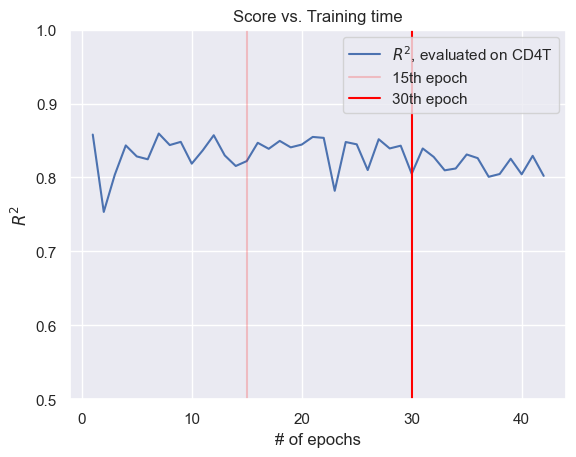

: 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(os.path.join('result', '4 Best Epoch', 'score_validation.csv'), index_col=0)
df = df[df['score'] > 0]

df.plot(y='score', label='$R^2$, evaluated on CD4T')
plt.title('Score vs. Training time')
plt.ylabel('$R^2$')
plt.xlabel('# of epochs')
plt.ylim([0.5, 1])
plt.axvline(x=15, ls='-', color='red', alpha=0.2, label='15th epoch')
plt.axvline(x=30, ls='-', color='red', label='30th epoch')
plt.legend();